<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/%5B0806new%5Dmachine_learning_for_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## memory 예측 (점진적 패턴, 느린 주기)

## 복잡한 memory 사용량 형태

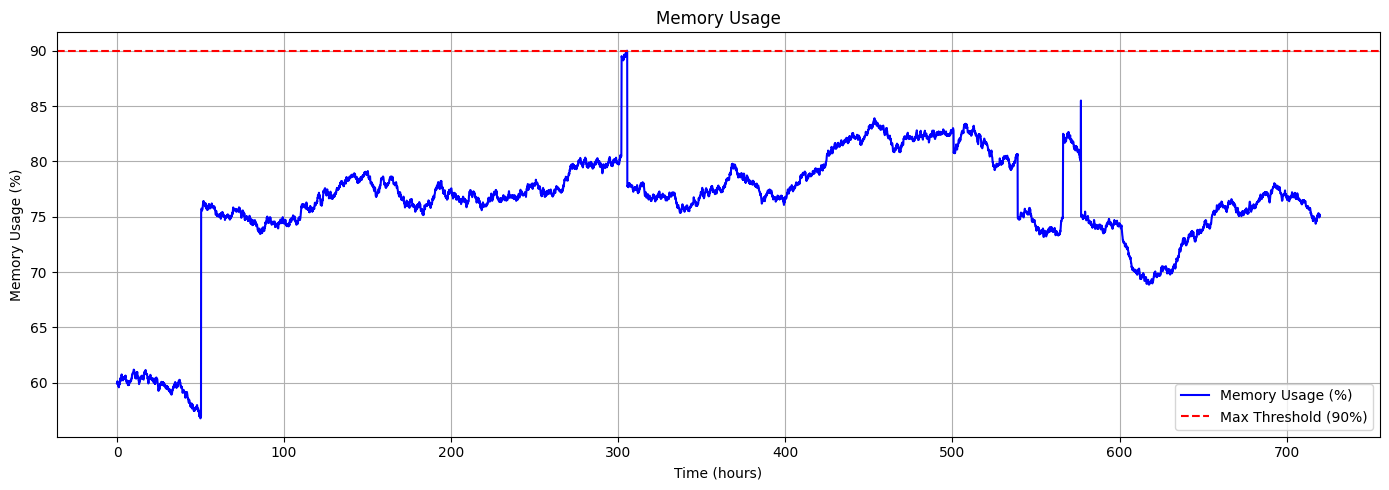

In [1]:
# 증설 필요한 상황
import numpy as np
import matplotlib.pyplot as plt

days = 30
interval_minutes = 5
steps_per_day = int(24 * 60 / interval_minutes)
total_steps = days * steps_per_day
time_hours = np.arange(total_steps) * (interval_minutes / 60)

baseline = 60
threshold = 90
growth_per_step = 0.001
small_noise_std = 0.1

gc_release_range = (5, 15)

# spike 설정
event_spikes = np.zeros(total_steps)
for _ in range(3):
    idx = np.random.randint(0, total_steps - 5)
    spike_val = np.random.uniform(3, 6)
    event_spikes[idx:idx+2] += spike_val

for _ in range(3):
    idx = np.random.randint(0, total_steps - 2)
    spike_val = np.random.uniform(40, 55)
    event_spikes[idx] += spike_val

memory_usage = []
current_mem = baseline

for i in range(total_steps):
    current_mem += growth_per_step + np.random.normal(0, small_noise_std) + event_spikes[i]

    # max threshold 초과하지 않도록 제한
    if current_mem > threshold:
        current_mem = threshold

    # GC 작동
    if current_mem >= threshold:
        release_amount = np.random.uniform(*gc_release_range)
        current_mem -= release_amount
        current_mem = max(current_mem, baseline)

    memory_usage.append(current_mem)

memory_usage = np.array(memory_usage)

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(time_hours, memory_usage, label="Memory Usage (%)", color='blue')
plt.axhline(threshold, color='red', linestyle='--', label="Max Threshold (90%)")
plt.title("Memory Usage")
plt.xlabel("Time (hours)")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
# 하루 시간 반복을 위해 모듈로 24
hour_of_day = time_hours % 24

# 업무시간: 08:00 ~ 17:30
working_hour_mask = (hour_of_day >= 8.0) & (hour_of_day < 17.5)
working_hour_memory = memory_usage[working_hour_mask]
working_hour_avg = np.mean(working_hour_memory)

print(f"업무시간 메모리 평균 사용량: {working_hour_avg:.2f}%")


업무시간 메모리 평균 사용량: 76.17%


## 1. CNN-LSTM 적용 + sliding window(5)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

days = 30
points_per_day = 24 * 12
total_points = days * points_per_day
time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
df = pd.DataFrame({'timestamp': time_index, 'memory': memory_usage}).set_index('timestamp')

scaler = MinMaxScaler()
memory_scaled =pd.DataFrame( scaler.fit_transform(df[['memory']]))

past_steps = 20
future_steps = 5

# ✅ 데이터 분할 (80:10:10)
n_total = len(memory_scaled)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

memory_train = memory_scaled.iloc[:n_train]
memory_val   = memory_scaled.iloc[n_train:n_train + n_val]
memory_test  = memory_scaled.iloc[n_train + n_val:]


# 시퀀스 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(memory_train, past_steps, future_steps)
X_val,   y_val   = create_sequences(memory_val, past_steps, future_steps)
X_test,  y_test  = create_sequences(memory_test, past_steps, future_steps)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), epochs=20, batch_size=16, verbose=1)

pred = model.predict(X_test).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0493
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0537e-04
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3304e-04
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.9932e-04
Epoch 5/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7923e-04
Epoch 6/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.8120e-04
Epoch 7/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.4696e-04
Epoch 8/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8568e-04
Epoch 9/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6486e-04
Epoch 10/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0780e-04
Epoch 11/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.8157e-04
Epoch 12/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.9945e-04
Epoch 13/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.4532e-04
Epoch 14/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5055e-04
Epoch

CNN-LSTM
MAE : 0.14652241789549736
RMSE: 0.18708788631757073
R²  : 0.9575296468680993


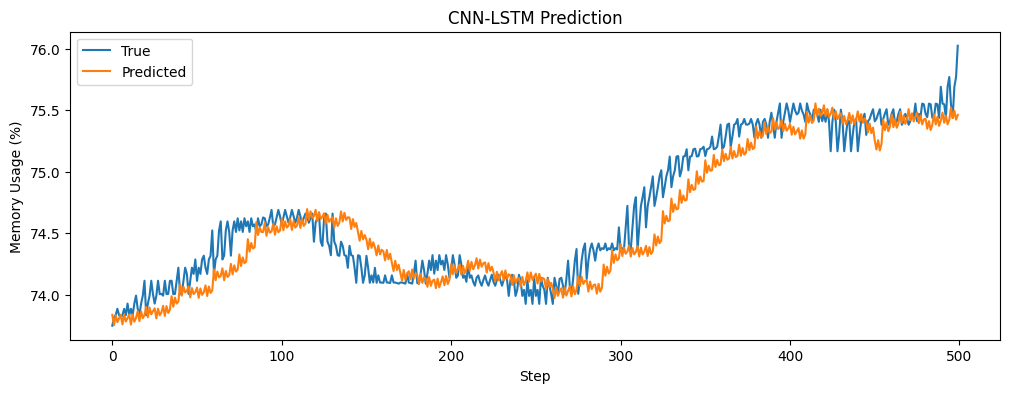

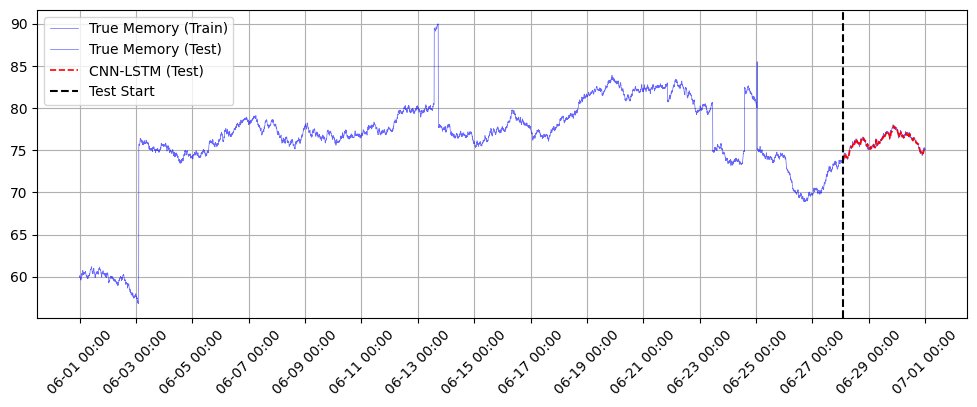

In [5]:
# plot

print("CNN-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}

plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['memory'][:test_start_idx]  # Test 시작 전까지
val_series = df['memory'][train_end:val_end] # validation data
test_series_true= df['memory'][test_start_idx:]

# test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

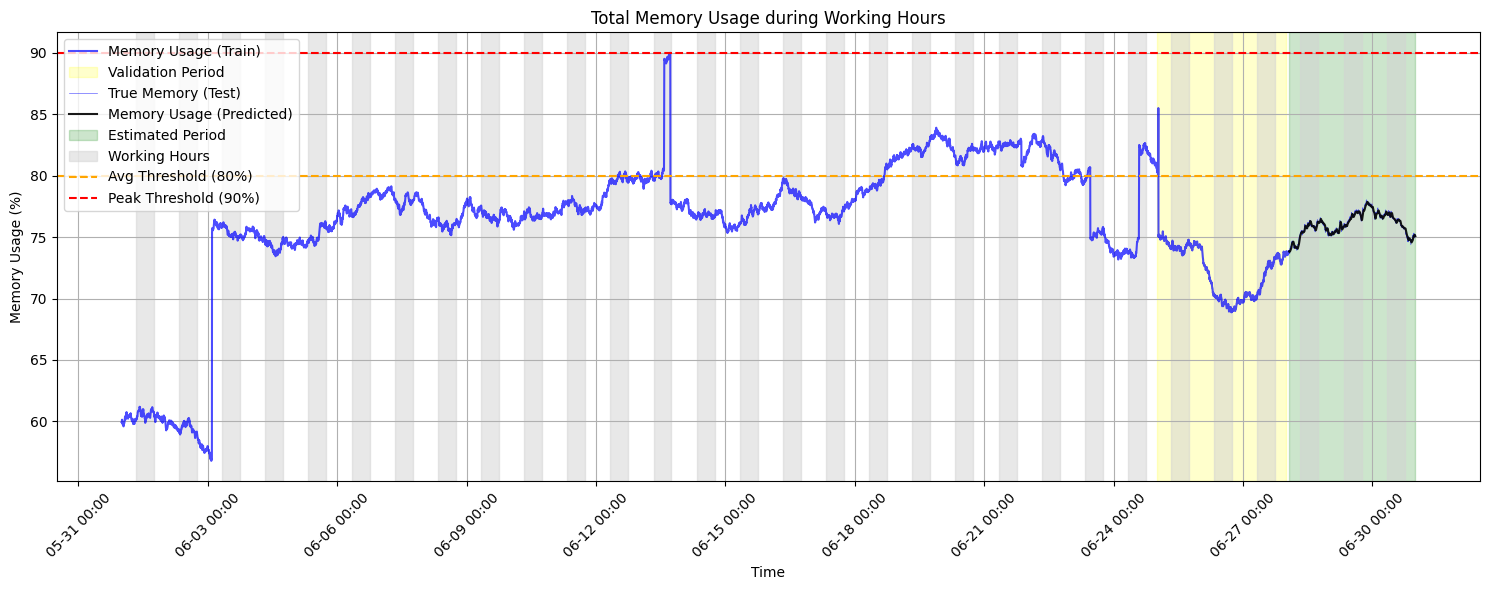

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['memory'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "memory_pred"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 memory 사용률 ≥ 80% (업무시간, 비업무시간 분리)
avg_threshold = 80
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 4. 조건 2: 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold)
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['memory'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="Memory Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="Memory Usage (Predicted)", color="black",alpha=0.9)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# # 업그레이드 신호 표시
# if len(upgrade_times) > 0:
#     ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total Memory Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("Memory Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# streamlit 위한 csv 저장
# 평균 사용률 저장
memory_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
memory_avg_df.to_csv("memory_avg_usage_CNN-LSTM.csv", index=False)

import json
with open("memory_accuracy_metrics_CNN-LSTM.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_CNN-LSTM.csv") # 전체 memory
test_series_pred.to_csv("memory_usage_predicted_only_CNN-LSTM.csv")
work_time.to_csv("memory_usage_working_hours_CNN-LSTM.csv")
daily_peak.to_csv("memory_peak_flag_per_day_CNN-LSTM.csv")

with open("upgrade_decision_CNN-LSTM.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("memory_plot_CNN-LSTM.png")


## 2. 단순 CNN

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


# CNN-only 모델
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# reshape for Conv1D
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model.fit(X_train_cnn, y_train, epochs=20, batch_size=16, verbose=1)
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)

pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0185
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2116e-04
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1843e-04
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4592e-04
Epoch 5/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2569e-04
Epoch 6/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7081e-04
Epoch 7/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2427e-04
Epoch 8/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6492e-04
Epoch 9/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0886e-04
Epoch 10/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6468e-04
Epoch 11/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4021e-04
Epoch 12/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6316e-04
Epoch 13/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5243e-04
Epoch 14/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8484e-04
Epoch 15/20
431/

CNN
MAE : 0.1465744877312432
RMSE: 0.18707748476172667
R²  : 0.9575485399530969


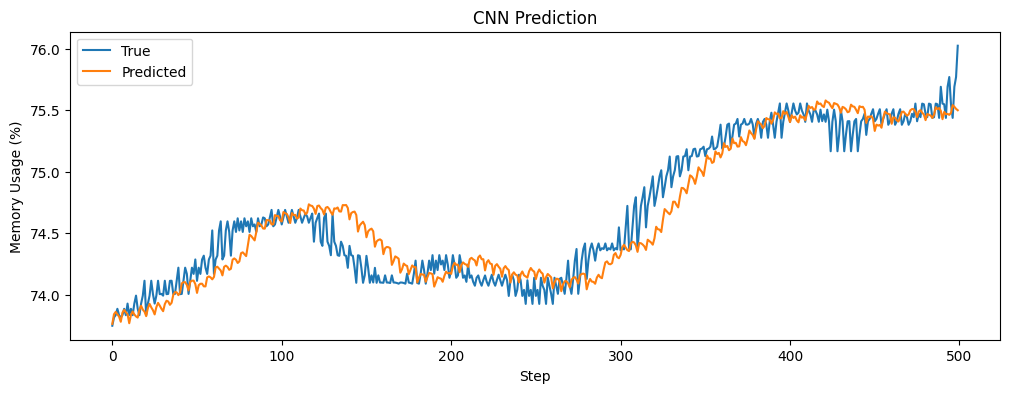

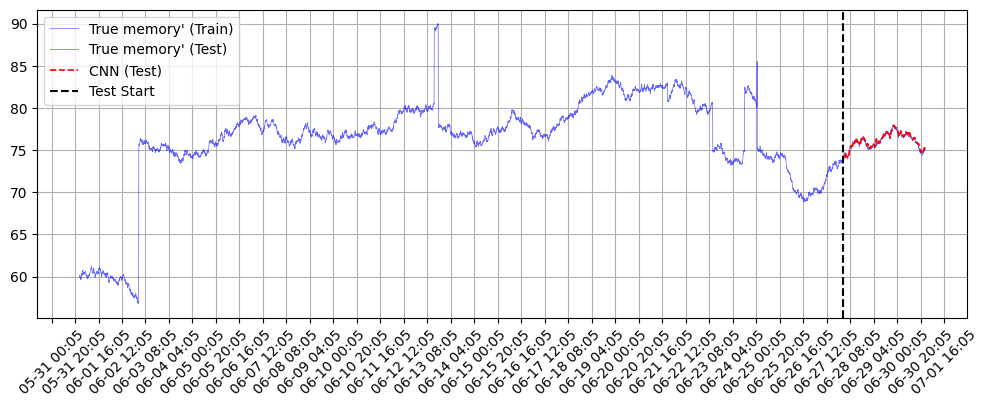

In [8]:
# plot

print("CNN")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}

plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['memory'][:test_start_idx]  # Test 시작 전까지
val_series = df['memory'][train_end:val_end] # validation data
test_series_true= df['memory'][test_start_idx:]

all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True Memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)

# validation
plt.plot(val_series, label="Validation Memory (Val)", color="blue", alpha = 0.4, linewidth = 0.5)
# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN (Test)", color="red", linestyle="--", linewidth = 1.2)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")


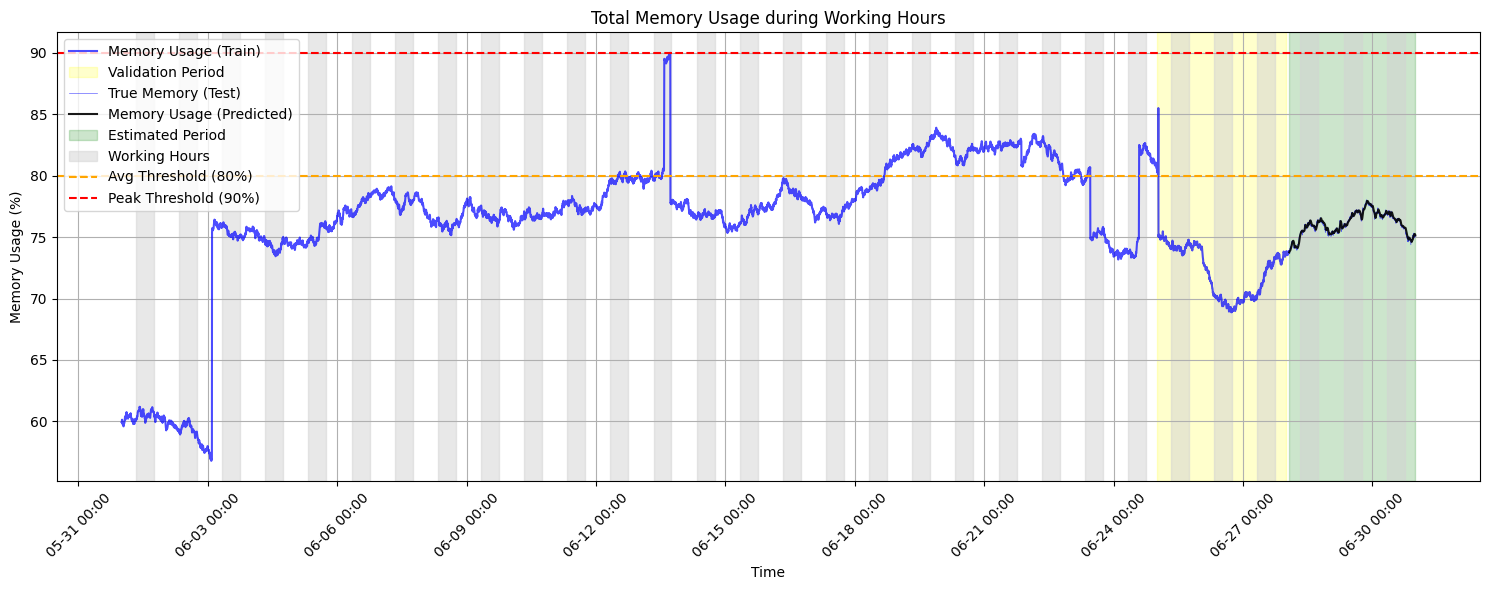

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['memory'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "memory_pred"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 memory 사용률 ≥ 80% (업무시간, 비업무시간 분리)
avg_threshold = 80
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 4. 조건 2: 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold)
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['memory'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="Memory Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="Memory Usage (Predicted)", color="black",alpha=0.9)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# # 업그레이드 신호 표시
# if len(upgrade_times) > 0:
#     ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total Memory Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("Memory Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# streamlit 위한 csv 저장
# 평균 사용률 저장
memory_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
memory_avg_df.to_csv("memory_avg_usage_CNN.csv", index=False)

import json
with open("memory_accuracy_metrics_CNN.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_CNN.csv") # 전체 memory
test_series_pred.to_csv("memory_usage_predicted_only_CNN.csv")
work_time.to_csv("memory_usage_working_hours_CNN.csv")
daily_peak.to_csv("memory_peak_flag_per_day_CNN.csv")

with open("upgrade_decision_CNN.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("memory_plot_CNN.png")


## CNN-BiLSTM + sliding window (5) + CNN 2층 쌓기

In [10]:
from tensorflow.keras.layers import Bidirectional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# reshape y to match CNN-BiLSTM output
y_train_re = y_train.reshape(-1, future_steps)
y_test_re  = y_test.reshape(-1, future_steps)

# ✅ CNN-BiLSTM 모델 구성
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, activation='tanh')),
    Dense(future_steps)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ✅ reshape for Conv1D & LSTM
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ✅ 학습
model.fit(X_train_cnn, y_train_re, epochs=20, batch_size=16, verbose=1)

# ✅ 예측
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test_re.reshape(-1, future_steps)

# ✅ 복원 (정규화 → 원래 단위 [%]로)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

# ✅ 성능 출력
print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,949 (261.52 KB)

 Trainable params: 66,949 (261.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0280
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.4808e-04
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.7699e-04
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.4956e-04
Epoch 5/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 6.4483e-04
Epoch 6/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.5771e-04
Epoch 7/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.6222e-04
Epoch 8/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.5397e-04
Epoch 9/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.8263e-04
Epoch 10/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.5624e-04
Epoch 11/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.7970e-04
Epoch 12/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.4378e-04
Epoch 13/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.4409e-04
Epoch 14/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.0713e-04
Epoch

CNN-BiLSTM
MAE : 0.2306473860744897
RMSE: 0.4232804044999631
R²  : 0.8451819465035728


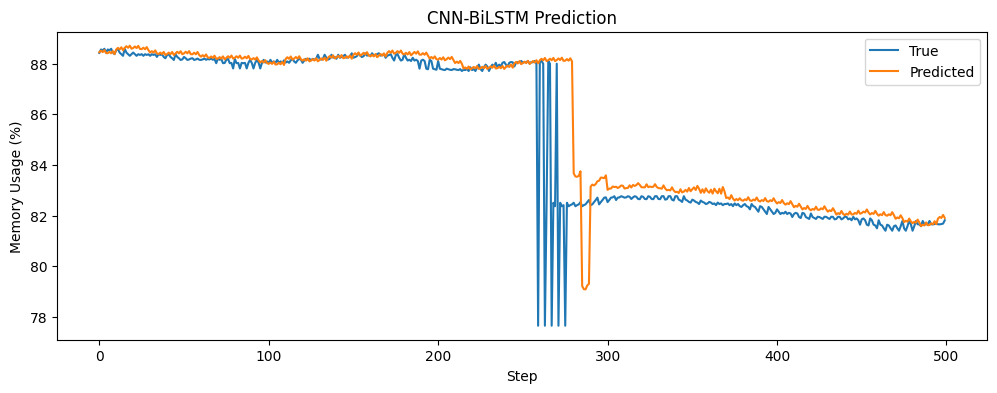

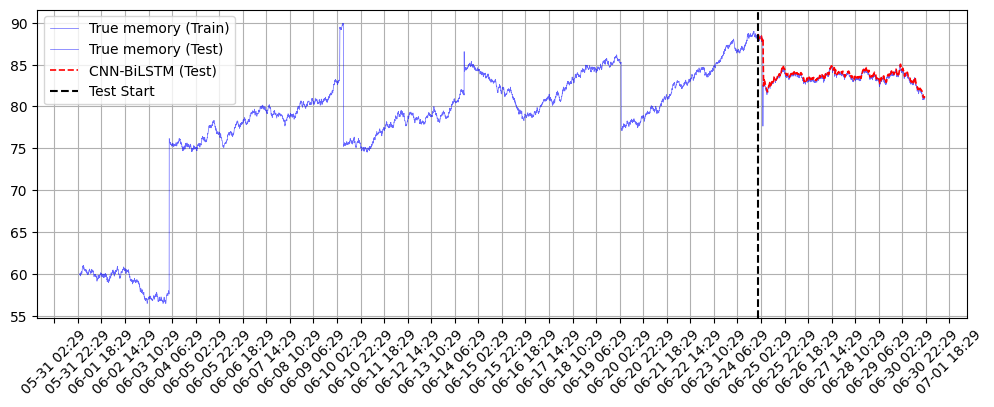

In [ ]:
# plot

print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))
metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN-BiLSTM Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)

test_start_idx = val_end + past_steps
train_series = df['memory'][:test_start_idx]  # Test 시작 전까지
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
val_series = df['memory'][train_end:val_end] # validation data
test_series_true= df['memory'][test_start_idx:]

all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True Memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)

# validation
plt.plot(val_series, label="Validation Memory (Val)", color="blue", alpha = 0.4, linewidth = 0.5)
# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="Bi-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['memory'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "memory_pred"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 memory 사용률 ≥ 80% (업무시간, 비업무시간 분리)
avg_threshold = 80
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 4. 조건 2: 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold)
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['memory'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="Memory Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="Memory Usage (Predicted)", color="black",alpha=0.9)
test_start = test_series_pred.index[0]
test_end = test_series_pred.index[-1]
ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# # 업그레이드 신호 표시
# if len(upgrade_times) > 0:
#     ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total Memory Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("Memory Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# streamlit 위한 csv 저장
# 평균 사용률 저장
memory_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
memory_avg_df.to_csv("memory_avg_usage_Bi-LSTM.csv", index=False)

import json
with open("memory_accuracy_metrics_Bi-LSTM.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_Bi-LSTM.csv") # 전체 memory
test_series_pred.to_csv("memory_usage_predicted_only_Bi-LSTM.csv")
work_time.to_csv("memory_usage_working_hours_Bi-LSTM.csv")
daily_peak.to_csv("memory_peak_flag_per_day_Bi-LSTM.csv")

with open("upgrade_decision_Bi-LSTM.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("memory_plot_Bi-LSTM.png")
